In [60]:
pip install scikeras

Note: you may need to restart the kernel to use updated packages.


In [61]:
pip install keras-tuner

Note: you may need to restart the kernel to use updated packages.


In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.layers import Dense, Input
from keras.models import Model
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras.optimizers import Adam

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

from scikeras.wrappers import KerasRegressor

In [63]:
path = './Files/After_Feature_Engineering/Split/'

In [64]:
def label_encoder(Y_train, Y_test):
    """
    Encode categorical labels using LabelEncoder and convert them to one-hot encoding.

    Parameters:
        Y_train (pandas.DataFrame): Training labels.
        Y_test (pandas.DataFrame): Testing labels.

    Returns:
        Tuple of encoded and one-hot encoded labels for nail spacing, number of sheathing panels,
        number of end studs, as well as the original Y_train and Y_test.
    """
    # Encode and one-hot encode 'Nail spacing [cm]'
    label_encoder_nail_spacing = LabelEncoder()
    Y_train['Nail spacing [cm]'] = label_encoder_nail_spacing.fit_transform(Y_train['Nail spacing [cm]'])
    Y_test['Nail spacing [cm]'] = label_encoder_nail_spacing.transform(Y_test['Nail spacing [cm]'])
    Y_train_onehot_nail_spacing = to_categorical(Y_train['Nail spacing [cm]'], num_classes=3)
    Y_test_onehot_nail_spacing = to_categorical(Y_test['Nail spacing [cm]'], num_classes=3)

    # Encode and one-hot encode 'Number sheathing panels'
    label_encoder_num_sheathing_panels = LabelEncoder()
    Y_train['Number sheathing panels'] = label_encoder_num_sheathing_panels.fit_transform(Y_train['Number sheathing panels'])
    Y_test['Number sheathing panels'] = label_encoder_num_sheathing_panels.transform(Y_test['Number sheathing panels'])
    Y_train_onehot_num_sheathing_panels = to_categorical(Y_train['Number sheathing panels'], num_classes=2)
    Y_test_onehot_num_sheathing_panels = to_categorical(Y_test['Number sheathing panels'], num_classes=2)

    # Encode and one-hot encode 'Number end studs'
    label_encoder_num_end_studs = LabelEncoder()
    Y_train['Number end studs'] = label_encoder_num_end_studs.fit_transform(Y_train['Number end studs'])
    Y_test['Number end studs'] = label_encoder_num_end_studs.transform(Y_test['Number end studs'])
    Y_train_onehot_num_end_studs = to_categorical(Y_train['Number end studs'], num_classes=6)
    Y_test_onehot_num_end_studs = to_categorical(Y_test['Number end studs'], num_classes=6)

    # Return the results
    return (
        Y_train_onehot_nail_spacing, Y_test_onehot_nail_spacing,
        Y_train_onehot_num_sheathing_panels, Y_test_onehot_num_sheathing_panels,
        Y_train_onehot_num_end_studs, Y_test_onehot_num_end_studs,
        Y_train, Y_test
    )


def plot_loss(history):
    """
    Plot training and validation loss over epochs.
    Uses logarithmic scale for the x-axis for better visualization.

    Parameters:
        history (keras.callbacks.History): The training history obtained from model training.

    Returns:
        None
    """
    plt.figure(figsize=(15, 6))

    # Plot training loss
    plt.subplot(1, 2, 1)
    for output in history.history.keys():
        if output.endswith('loss') and not output.startswith('val_') and output != 'loss':
            plt.plot(history.history[output], label=output)

    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.xscale('log')
    plt.ylabel('Loss')
    plt.legend()

    # Plot validation loss
    plt.subplot(1, 2, 2)
    for output in history.history.keys():
        if output.startswith('val_') and output.endswith('loss') and output != 'val_loss':
            plt.plot(history.history[output], label=output[4:])

    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.xscale('log')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [65]:
X_train_C_1 = pd.read_csv(path + "X_train_C_part1_FE.csv", low_memory=False)
X_test_C_1 = pd.read_csv(path + "X_test_C_part1_FE.csv", low_memory=False)

Y_train_C_1 = pd.read_csv(path + "Y_train_C_part1_FE.csv", low_memory=False)
Y_test_C_1 = pd.read_csv(path + "Y_test_C_part1_FE.csv", low_memory=False)

In [66]:
# One hot encoding Y
Y_train_onehot_nail_spacing, Y_test_onehot_nail_spacing, Y_train_onehot_num_sheathing_panels, Y_test_onehot_num_sheathing_panels, Y_train_onehot_num_end_studs, Y_test_onehot_num_end_studs, Y_train_C_1, Y_test_C_1 = label_encoder(Y_train_C_1, Y_test_C_1)

Baseline

Epoch 1/10
1557/1557 [==============================] - 6s 2ms/step - loss: 97.9890 - nail_spacing_loss: 2.2704 - num_sheathing_panels_loss: 1.3576 - num_end_studs_loss: 7.8968 - total_num_studs_loss: 56.7541 - holddown/ats_loss: 29.7103 - nail_spacing_accuracy: 0.5262 - num_sheathing_panels_accuracy: 0.1984 - num_end_studs_accuracy: 0.1420 - total_num_studs_mae: 5.7939 - holddown/ats_mae: 3.4679 - val_loss: 54.4797 - val_nail_spacing_loss: 0.9503 - val_num_sheathing_panels_loss: 1.2761 - val_num_end_studs_loss: 8.6808 - val_total_num_studs_loss: 21.3318 - val_holddown/ats_loss: 22.2407 - val_nail_spacing_accuracy: 0.6558 - val_num_sheathing_panels_accuracy: 0.2195 - val_num_end_studs_accuracy: 0.1425 - val_total_num_studs_mae: 3.2736 - val_holddown/ats_mae: 3.1893 - lr: 0.0010
Epoch 2/10
1557/1557 [==============================] - 3s 2ms/step - loss: 45.7253 - nail_spacing_loss: 0.8969 - num_sheathing_panels_loss: 1.3487 - num_end_studs_loss: 8.5478 - total_num_studs_loss: 16.3704 - 

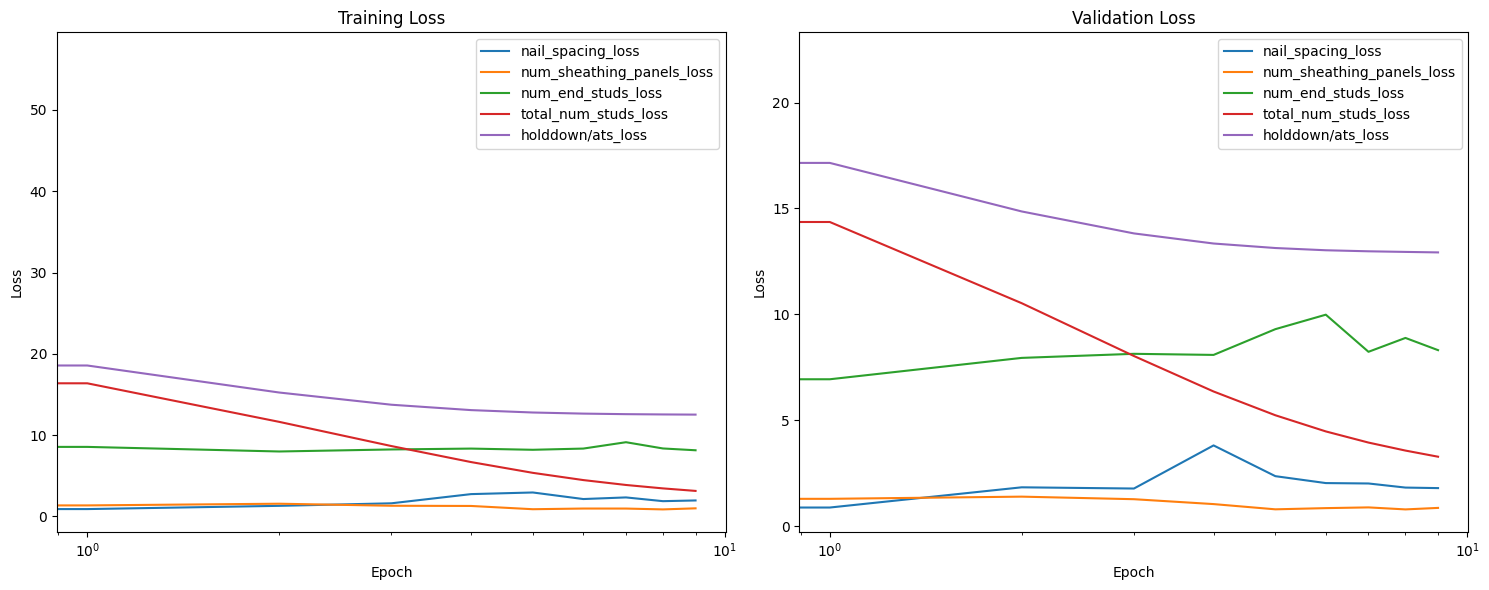

In [49]:
# Define the input layer
input_layer_C_1 = Input(shape=(X_train_C_1.shape[1],))

# One hot encoding Y
Y_train_onehot_nail_spacing, Y_test_onehot_nail_spacing, Y_train_onehot_num_sheathing_panels, Y_test_onehot_num_sheathing_panels, Y_train_onehot_num_end_studs, Y_test_onehot_num_end_studs, Y_train_C_1, Y_test_C_1 = label_encoder(Y_train_C_1, Y_test_C_1)

# Output layers
nail_spacing_output = Dense(3, activation='linear', name='nail_spacing')(input_layer_C_1)
num_sheathing_panels_output = Dense(2, activation='linear', name='num_sheathing_panels')(input_layer_C_1)
num_end_studs_output = Dense(6, activation='linear', name='num_end_studs')(input_layer_C_1)
total_num_studs_output = Dense(1, activation='linear', name='total_num_studs')(input_layer_C_1)
holddown_model_output = Dense(1, activation='linear', name='holddown/ats')(input_layer_C_1)

# Combine the outputs into a single model
model_C_1 = Model(inputs=input_layer_C_1, outputs=[nail_spacing_output, num_sheathing_panels_output, 
                                           num_end_studs_output, total_num_studs_output, 
                                           holddown_model_output])

# Compile the model
model_C_1.compile(optimizer='adam', 
              loss={'nail_spacing': 'categorical_crossentropy',
                    'num_sheathing_panels': 'categorical_crossentropy',
                    'num_end_studs': 'categorical_crossentropy',
                    'total_num_studs': 'mean_squared_error',
                    'holddown/ats': 'mean_squared_error'
                    },
              metrics={'nail_spacing': 'accuracy',
                       'num_sheathing_panels': 'accuracy',
                       'num_end_studs': 'accuracy',
                       'total_num_studs': 'mae',
                       'holddown/ats': 'mae'
                       })

# Implement ReduceLROnPlateau callback
# Went from 0.02 to 0.008 in total loss with this line
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)

# Train the model
history_C_1 = model_C_1.fit(X_train_C_1, {'nail_spacing': Y_train_onehot_nail_spacing, 
                    'num_sheathing_panels': Y_train_onehot_num_sheathing_panels,
                    'num_end_studs': Y_train_onehot_num_end_studs,
                    'total_num_studs': Y_train_C_1['Total number studs'],
                    'holddown/ats': Y_train_C_1['HoldDown Model / ATS']
                    },
          epochs=10, batch_size=32, validation_data = (X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing,
                                                                        'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                                                        'num_end_studs': Y_test_onehot_num_end_studs,
                                                                        'total_num_studs': Y_test_C_1['Total number studs'],
                                                                        'holddown/ats': Y_test_C_1['HoldDown Model / ATS']
                                             }), callbacks=[reduce_lr])

# Plot training and validation loss
plot_loss(history_C_1)

In [50]:
# Evaluate the model on the test set
evaluation_results = model_C_1.evaluate(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing, 
                                             'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                             'num_end_studs': Y_test_onehot_num_end_studs,
                                             'total_num_studs': Y_test_C_1['Total number studs'],
                                             'holddown/ats': Y_test_C_1['HoldDown Model / ATS']
                                             },
                                    batch_size=32)

# Extract and print the accuracy for each output
output_metrics = {name: value for name, value in zip(model_C_1.metrics_names, evaluation_results)}
print("Metrics on Test Set:")
for output_name, metric_value in output_metrics.items():
    print(f"{output_name}: {metric_value}")

390/390 [==============================] - 1s 1ms/step - loss: 27.1928 - nail_spacing_loss: 1.8021 - num_sheathing_panels_loss: 0.8677 - num_end_studs_loss: 8.3130 - total_num_studs_loss: 3.2839 - holddown/ats_loss: 12.9262 - nail_spacing_accuracy: 0.3944 - num_sheathing_panels_accuracy: 0.3539 - num_end_studs_accuracy: 0.2065 - total_num_studs_mae: 1.2337 - holddown/ats_mae: 2.6566
Metrics on Test Set:
loss: 27.19284439086914
nail_spacing_loss: 1.8021272420883179
num_sheathing_panels_loss: 0.8677060008049011
num_end_studs_loss: 8.31298542022705
total_num_studs_loss: 3.283867359161377
holddown/ats_loss: 12.926156997680664
nail_spacing_accuracy: 0.39436280727386475
num_sheathing_panels_accuracy: 0.35389062762260437
num_end_studs_accuracy: 0.20653657615184784
total_num_studs_mae: 1.2337290048599243
holddown/ats_mae: 2.6565699577331543


Other model

Epoch 1/10
1557/1557 [==============================] - 6s 3ms/step - loss: 36.8687 - nail_spacing_loss: 0.8149 - num_sheathing_panels_loss: 0.3934 - num_end_studs_loss: 0.8398 - total_num_studs_loss: 23.4296 - holddown/ats_loss: 11.3911 - nail_spacing_accuracy: 0.6545 - num_sheathing_panels_accuracy: 0.8260 - num_end_studs_accuracy: 0.6840 - total_num_studs_mae: 3.3854 - holddown/ats_mae: 2.2352 - val_loss: 6.1757 - val_nail_spacing_loss: 0.6314 - val_num_sheathing_panels_loss: 0.2709 - val_num_end_studs_loss: 0.4412 - val_total_num_studs_loss: 1.9904 - val_holddown/ats_loss: 2.8418 - val_nail_spacing_accuracy: 0.7340 - val_num_sheathing_panels_accuracy: 0.8861 - val_num_end_studs_accuracy: 0.8262 - val_total_num_studs_mae: 0.9382 - val_holddown/ats_mae: 0.9815 - lr: 0.0010
Epoch 2/10
1557/1557 [==============================] - 4s 2ms/step - loss: 12.3897 - nail_spacing_loss: 0.6763 - num_sheathing_panels_loss: 0.2919 - num_end_studs_loss: 0.5485 - total_num_studs_loss: 5.0609 - hold

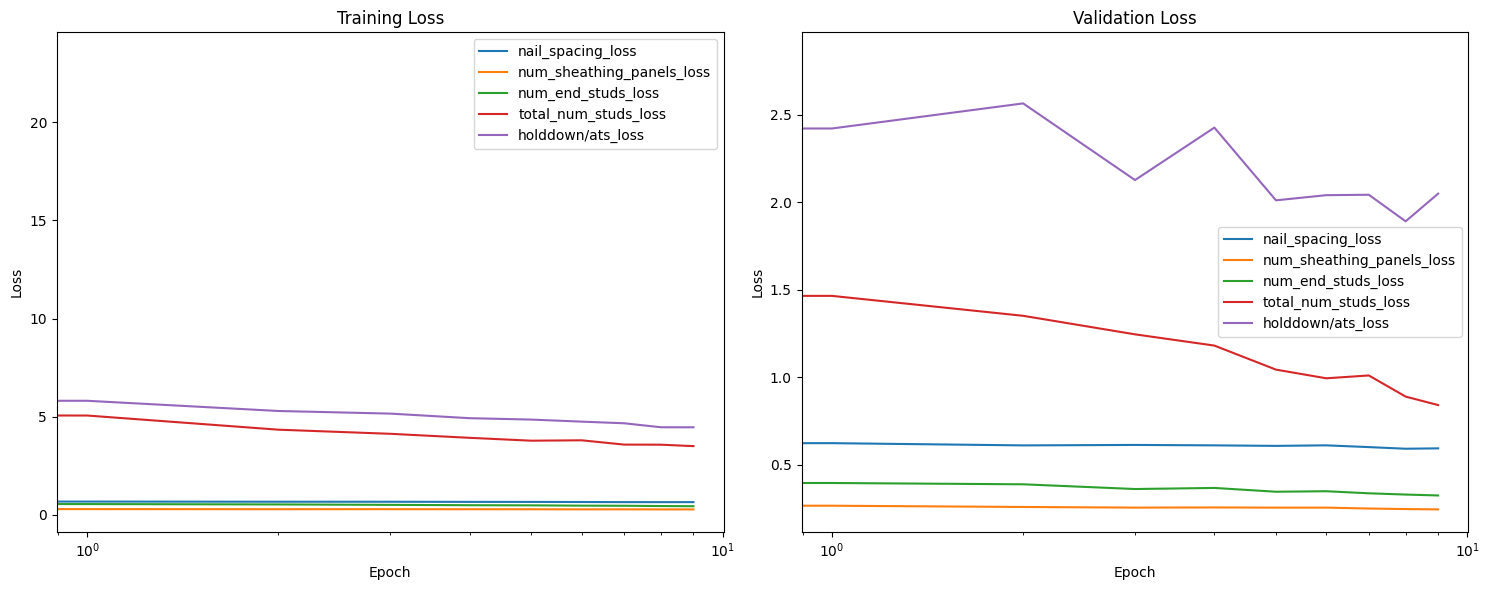

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [51]:
from keras.layers import Dense, Dropout, BatchNormalization, Input
from keras.models import Model
from keras.callbacks import ReduceLROnPlateau
from keras.utils import plot_model

def create_model(layer_sizes=[64, 32], dropout_rate=0.5):
    input_layer = Input(shape=(X_train_C_1.shape[1],))
    
    x = input_layer
    for size in layer_sizes:
        x = Dense(size, activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)

    # Output layers
    nail_spacing_output = Dense(3, activation='softmax', name='nail_spacing')(x)
    num_sheathing_panels_output = Dense(2, activation='softmax', name='num_sheathing_panels')(x)
    num_end_studs_output = Dense(6, activation='softmax', name='num_end_studs')(x)
    total_num_studs_output = Dense(1, activation='linear', name='total_num_studs')(x)
    holddown_model_output = Dense(1, activation='linear', name='holddown/ats')(x)

    model = Model(inputs=input_layer, outputs=[nail_spacing_output, num_sheathing_panels_output, 
                                               num_end_studs_output, total_num_studs_output, 
                                               holddown_model_output])

    model.compile(optimizer='adam', 
                  loss={'nail_spacing': 'categorical_crossentropy',
                        'num_sheathing_panels': 'categorical_crossentropy',
                        'num_end_studs': 'categorical_crossentropy',
                        'total_num_studs': 'mean_squared_error',
                        'holddown/ats': 'mean_squared_error'},
                  metrics={'nail_spacing': 'accuracy',
                           'num_sheathing_panels': 'accuracy',
                           'num_end_studs': 'accuracy',
                           'total_num_studs': 'mae',
                           'holddown/ats': 'mae'})

    return model

# Create the model with specific parameters
model_C_1 = create_model(layer_sizes=[128, 64], dropout_rate=0.3)

# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.00001)

# Train the model
history_C_1 = model_C_1.fit(
    X_train_C_1, 
    {'nail_spacing': Y_train_onehot_nail_spacing, 
     'num_sheathing_panels': Y_train_onehot_num_sheathing_panels,
     'num_end_studs': Y_train_onehot_num_end_studs,
     'total_num_studs': Y_train_C_1['Total number studs'],
     'holddown/ats': Y_train_C_1['HoldDown Model / ATS']},
    epochs=10, 
    batch_size=32, 
    validation_data=(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing,
                                  'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                  'num_end_studs': Y_test_onehot_num_end_studs,
                                  'total_num_studs': Y_test_C_1['Total number studs'],
                                  'holddown/ats': Y_test_C_1['HoldDown Model / ATS']}),
    callbacks=[reduce_lr]
)



plot_loss(history_C_1)

# Optionally, visualize the model structure
plot_model(model_C_1, to_file='model_C_1.png', show_shapes=True)

In [52]:
# Evaluate the model on the test set
evaluation_results = model_C_1.evaluate(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing, 
                                             'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                             'num_end_studs': Y_test_onehot_num_end_studs,
                                             'total_num_studs': Y_test_C_1['Total number studs'],
                                             'holddown/ats': Y_test_C_1['HoldDown Model / ATS']
                                             },
                                    batch_size=32)

# Extract and print the accuracy for each output
output_metrics = {name: value for name, value in zip(model_C_1.metrics_names, evaluation_results)}
print("Metrics on Test Set:")
for output_name, metric_value in output_metrics.items():
    print(f"{output_name}: {metric_value}")

390/390 [==============================] - 1s 1ms/step - loss: 4.0515 - nail_spacing_loss: 0.5932 - num_sheathing_panels_loss: 0.2442 - num_end_studs_loss: 0.3239 - total_num_studs_loss: 0.8407 - holddown/ats_loss: 2.0496 - nail_spacing_accuracy: 0.7491 - num_sheathing_panels_accuracy: 0.8897 - num_end_studs_accuracy: 0.8638 - total_num_studs_mae: 0.6294 - holddown/ats_mae: 0.7831
Metrics on Test Set:
loss: 4.051511287689209
nail_spacing_loss: 0.5931867361068726
num_sheathing_panels_loss: 0.24416722357273102
num_end_studs_loss: 0.3238731622695923
total_num_studs_loss: 0.84070885181427
holddown/ats_loss: 2.0495762825012207
nail_spacing_accuracy: 0.7490564584732056
num_sheathing_panels_accuracy: 0.8897454142570496
num_end_studs_accuracy: 0.8638079166412354
total_num_studs_mae: 0.6293722987174988
holddown/ats_mae: 0.7831124663352966


In [53]:
import kerastuner as kt
from tensorflow import keras
from keras.layers import Dense, Dropout, BatchNormalization, Input, LeakyReLU
from keras.regularizers import l1_l2
from keras.models import Model

# Path to the existing tuner directory
tuner_dir = 'my_dir/with_regularization'

# Check if the directory exists and delete it
if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)


def build_model(hp):
    input_layer = Input(shape=(X_train_C_1.shape[1],))
    x = input_layer

    # Tune the number of layers and their sizes
    for i in range(hp.Int('num_layers', 1, 3)):
        x = Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=128, step=32),
                  activation='linear',  # Linear activation before LeakyReLU
                  kernel_regularizer=l1_l2(l1=hp.Float('l1', min_value=1e-5, max_value=1e-2, sampling='LOG'),
                                           l2=hp.Float('l2', min_value=1e-5, max_value=1e-2, sampling='LOG')))(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=hp.Float('leaky_alpha_' + str(i), min_value=0.01, max_value=0.3, step=0.05))(x)
        x = Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.3, step=0.1))(x)

    # Output layers
    nail_spacing_output = Dense(3, activation='softmax', name='nail_spacing')(x)
    num_sheathing_panels_output = Dense(2, activation='softmax', name='num_sheathing_panels')(x)
    num_end_studs_output = Dense(6, activation='softmax', name='num_end_studs')(x)
    total_num_studs_output = Dense(1, activation='linear', name='total_num_studs')(x)
    holddown_model_output = Dense(1, activation='linear', name='holddown/ats')(x)

    model = Model(inputs=input_layer, outputs=[nail_spacing_output, num_sheathing_panels_output, 
                                               num_end_studs_output, total_num_studs_output, 
                                               holddown_model_output])

    # Learning rate schedule
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=hp.Float('initial_learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG'),
        decay_steps=10000,
        decay_rate=0.9)

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss={'nail_spacing': 'categorical_crossentropy',
                        'num_sheathing_panels': 'categorical_crossentropy',
                        'num_end_studs': 'categorical_crossentropy',
                        'total_num_studs': 'mean_squared_error',
                        'holddown/ats': 'mean_squared_error'},
                  metrics={'nail_spacing': 'accuracy',
                           'num_sheathing_panels': 'accuracy',
                           'num_end_studs': 'accuracy',
                           'total_num_studs': 'mae',
                           'holddown/ats': 'mae'})

    return model

# Create a tuner instance
tuner = kt.Hyperband(build_model,
                     objective='val_loss',
                     max_epochs=10,
                     factor=5,
                     directory='my_dir',
                     project_name='with_regularization')

# Start the hyperparameter search
tuner.search(X_train_C_1, {'nail_spacing': Y_train_onehot_nail_spacing, 
                           'num_sheathing_panels': Y_train_onehot_num_sheathing_panels,
                           'num_end_studs': Y_train_onehot_num_end_studs,
                           'total_num_studs': Y_train_C_1['Total number studs'],
                           'holddown/ats': Y_train_C_1['HoldDown Model / ATS']},
             epochs=10,
             validation_data=(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing,
                                          'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                          'num_end_studs': Y_test_onehot_num_end_studs,
                                          'total_num_studs': Y_test_C_1['Total number studs'],
                                          'holddown/ats': Y_test_C_1['HoldDown Model / ATS']}))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 13 Complete [00h 00m 37s]
val_loss: 5.7646050453186035

Best val_loss So Far: 3.9961485862731934
Total elapsed time: 00h 04m 38s


390/390 [==============================] - 1s 1ms/step - loss: 3.9961 - nail_spacing_loss: 0.5194 - num_sheathing_panels_loss: 0.2066 - num_end_studs_loss: 0.2956 - total_num_studs_loss: 0.8750 - holddown/ats_loss: 1.8408 - nail_spacing_accuracy: 0.7718 - num_sheathing_panels_accuracy: 0.9031 - num_end_studs_accuracy: 0.8773 - total_num_studs_mae: 0.6296 - holddown/ats_mae: 0.7495
Evaluation result on Test Data: [3.9961485862731934, 0.5193747878074646, 0.20660142600536346, 0.2955563962459564, 0.8749871253967285, 1.8407622575759888, 0.7717819213867188, 0.9030755758285522, 0.8772986531257629, 0.6296342015266418, 0.7494892477989197]
Epoch 1/200
1557/1557 [==============================] - 7s 3ms/step - loss: 13.8522 - nail_spacing_loss: 0.6449 - num_sheathing_panels_loss: 0.2788 - num_end_studs_loss: 0.4730 - total_num_studs_loss: 6.6844 - holddown/ats_loss: 5.6533 - nail_spacing_accuracy: 0.7268 - num_sheathing_panels_accuracy: 0.8796 - num_end_studs_accuracy: 0.8087 - total_num_studs_ma

Epoch 11/200
1557/1557 [==============================] - 4s 3ms/step - loss: 6.5880 - nail_spacing_loss: 0.5547 - num_sheathing_panels_loss: 0.2246 - num_end_studs_loss: 0.3340 - total_num_studs_loss: 2.0453 - holddown/ats_loss: 3.1377 - nail_spacing_accuracy: 0.7628 - num_sheathing_panels_accuracy: 0.8953 - num_end_studs_accuracy: 0.8605 - total_num_studs_mae: 1.0657 - holddown/ats_mae: 1.1662 - val_loss: 3.9881 - val_nail_spacing_loss: 0.5111 - val_num_sheathing_panels_loss: 0.2093 - val_num_end_studs_loss: 0.2746 - val_total_num_studs_loss: 0.8564 - val_holddown/ats_loss: 1.8398 - val_nail_spacing_accuracy: 0.7800 - val_num_sheathing_panels_accuracy: 0.9012 - val_num_end_studs_accuracy: 0.8819 - val_total_num_studs_mae: 0.6260 - val_holddown/ats_mae: 0.7621
Epoch 12/200
1557/1557 [==============================] - 4s 3ms/step - loss: 6.5002 - nail_spacing_loss: 0.5486 - num_sheathing_panels_loss: 0.2246 - num_end_studs_loss: 0.3354 - total_num_studs_loss: 1.9998 - holddown/ats_loss

Epoch 22/200
1557/1557 [==============================] - 4s 3ms/step - loss: 6.0986 - nail_spacing_loss: 0.5405 - num_sheathing_panels_loss: 0.2172 - num_end_studs_loss: 0.3171 - total_num_studs_loss: 1.8221 - holddown/ats_loss: 2.8519 - nail_spacing_accuracy: 0.7686 - num_sheathing_panels_accuracy: 0.8988 - num_end_studs_accuracy: 0.8667 - total_num_studs_mae: 1.0081 - holddown/ats_mae: 1.1061 - val_loss: 3.7276 - val_nail_spacing_loss: 0.5032 - val_num_sheathing_panels_loss: 0.1967 - val_num_end_studs_loss: 0.2611 - val_total_num_studs_loss: 0.6880 - val_holddown/ats_loss: 1.7279 - val_nail_spacing_accuracy: 0.7806 - val_num_sheathing_panels_accuracy: 0.9042 - val_num_end_studs_accuracy: 0.8922 - val_total_num_studs_mae: 0.5690 - val_holddown/ats_mae: 0.7301
Epoch 23/200
1557/1557 [==============================] - 4s 3ms/step - loss: 6.1397 - nail_spacing_loss: 0.5379 - num_sheathing_panels_loss: 0.2181 - num_end_studs_loss: 0.3195 - total_num_studs_loss: 1.8410 - holddown/ats_loss

Epoch 33/200
1557/1557 [==============================] - 4s 3ms/step - loss: 5.8886 - nail_spacing_loss: 0.5359 - num_sheathing_panels_loss: 0.2145 - num_end_studs_loss: 0.3080 - total_num_studs_loss: 1.7193 - holddown/ats_loss: 2.7540 - nail_spacing_accuracy: 0.7719 - num_sheathing_panels_accuracy: 0.8996 - num_end_studs_accuracy: 0.8704 - total_num_studs_mae: 0.9798 - holddown/ats_mae: 1.0885 - val_loss: 3.6947 - val_nail_spacing_loss: 0.5002 - val_num_sheathing_panels_loss: 0.1911 - val_num_end_studs_loss: 0.2608 - val_total_num_studs_loss: 0.6553 - val_holddown/ats_loss: 1.7309 - val_nail_spacing_accuracy: 0.7828 - val_num_sheathing_panels_accuracy: 0.9075 - val_num_end_studs_accuracy: 0.8918 - val_total_num_studs_mae: 0.5587 - val_holddown/ats_mae: 0.7224
Epoch 34/200
1557/1557 [==============================] - 4s 3ms/step - loss: 5.8185 - nail_spacing_loss: 0.5336 - num_sheathing_panels_loss: 0.2113 - num_end_studs_loss: 0.3067 - total_num_studs_loss: 1.7058 - holddown/ats_loss

Epoch 44/200
1557/1557 [==============================] - 4s 3ms/step - loss: 5.7175 - nail_spacing_loss: 0.5319 - num_sheathing_panels_loss: 0.2093 - num_end_studs_loss: 0.3058 - total_num_studs_loss: 1.6189 - holddown/ats_loss: 2.7031 - nail_spacing_accuracy: 0.7728 - num_sheathing_panels_accuracy: 0.9018 - num_end_studs_accuracy: 0.8717 - total_num_studs_mae: 0.9506 - holddown/ats_mae: 1.0767 - val_loss: 3.6126 - val_nail_spacing_loss: 0.4900 - val_num_sheathing_panels_loss: 0.1871 - val_num_end_studs_loss: 0.2536 - val_total_num_studs_loss: 0.6428 - val_holddown/ats_loss: 1.6913 - val_nail_spacing_accuracy: 0.7888 - val_num_sheathing_panels_accuracy: 0.9103 - val_num_end_studs_accuracy: 0.8941 - val_total_num_studs_mae: 0.5721 - val_holddown/ats_mae: 0.7331
Epoch 45/200
1557/1557 [==============================] - 4s 3ms/step - loss: 5.6685 - nail_spacing_loss: 0.5283 - num_sheathing_panels_loss: 0.2079 - num_end_studs_loss: 0.3020 - total_num_studs_loss: 1.6187 - holddown/ats_loss

Epoch 55/200
1557/1557 [==============================] - 4s 3ms/step - loss: 5.5277 - nail_spacing_loss: 0.5225 - num_sheathing_panels_loss: 0.2026 - num_end_studs_loss: 0.2970 - total_num_studs_loss: 1.5428 - holddown/ats_loss: 2.6284 - nail_spacing_accuracy: 0.7779 - num_sheathing_panels_accuracy: 0.9082 - num_end_studs_accuracy: 0.8749 - total_num_studs_mae: 0.9252 - holddown/ats_mae: 1.0644 - val_loss: 3.5652 - val_nail_spacing_loss: 0.4840 - val_num_sheathing_panels_loss: 0.1846 - val_num_end_studs_loss: 0.2484 - val_total_num_studs_loss: 0.6219 - val_holddown/ats_loss: 1.6927 - val_nail_spacing_accuracy: 0.7957 - val_num_sheathing_panels_accuracy: 0.9146 - val_num_end_studs_accuracy: 0.8915 - val_total_num_studs_mae: 0.5356 - val_holddown/ats_mae: 0.6940
Epoch 56/200
1557/1557 [==============================] - 4s 3ms/step - loss: 5.4770 - nail_spacing_loss: 0.5212 - num_sheathing_panels_loss: 0.2012 - num_end_studs_loss: 0.2944 - total_num_studs_loss: 1.5285 - holddown/ats_loss

Epoch 66/200
1557/1557 [==============================] - 4s 3ms/step - loss: 5.3231 - nail_spacing_loss: 0.5144 - num_sheathing_panels_loss: 0.1968 - num_end_studs_loss: 0.2878 - total_num_studs_loss: 1.4867 - holddown/ats_loss: 2.5165 - nail_spacing_accuracy: 0.7818 - num_sheathing_panels_accuracy: 0.9121 - num_end_studs_accuracy: 0.8788 - total_num_studs_mae: 0.9046 - holddown/ats_mae: 1.0370 - val_loss: 3.3202 - val_nail_spacing_loss: 0.4701 - val_num_sheathing_panels_loss: 0.1703 - val_num_end_studs_loss: 0.2383 - val_total_num_studs_loss: 0.6152 - val_holddown/ats_loss: 1.5060 - val_nail_spacing_accuracy: 0.7973 - val_num_sheathing_panels_accuracy: 0.9224 - val_num_end_studs_accuracy: 0.8991 - val_total_num_studs_mae: 0.5277 - val_holddown/ats_mae: 0.6515
Epoch 67/200
1557/1557 [==============================] - 4s 3ms/step - loss: 5.2555 - nail_spacing_loss: 0.5131 - num_sheathing_panels_loss: 0.1952 - num_end_studs_loss: 0.2895 - total_num_studs_loss: 1.4428 - holddown/ats_loss

Epoch 77/200
1557/1557 [==============================] - 4s 3ms/step - loss: 5.2335 - nail_spacing_loss: 0.5131 - num_sheathing_panels_loss: 0.1922 - num_end_studs_loss: 0.2849 - total_num_studs_loss: 1.4435 - holddown/ats_loss: 2.4916 - nail_spacing_accuracy: 0.7830 - num_sheathing_panels_accuracy: 0.9139 - num_end_studs_accuracy: 0.8791 - total_num_studs_mae: 0.8885 - holddown/ats_mae: 1.0316 - val_loss: 3.2859 - val_nail_spacing_loss: 0.4713 - val_num_sheathing_panels_loss: 0.1691 - val_num_end_studs_loss: 0.2337 - val_total_num_studs_loss: 0.6202 - val_holddown/ats_loss: 1.4842 - val_nail_spacing_accuracy: 0.7987 - val_num_sheathing_panels_accuracy: 0.9252 - val_num_end_studs_accuracy: 0.8992 - val_total_num_studs_mae: 0.5383 - val_holddown/ats_mae: 0.6387
Epoch 78/200
1557/1557 [==============================] - 4s 3ms/step - loss: 5.1870 - nail_spacing_loss: 0.5104 - num_sheathing_panels_loss: 0.1925 - num_end_studs_loss: 0.2825 - total_num_studs_loss: 1.4487 - holddown/ats_loss

Epoch 88/200
1557/1557 [==============================] - 4s 3ms/step - loss: 5.1528 - nail_spacing_loss: 0.5071 - num_sheathing_panels_loss: 0.1919 - num_end_studs_loss: 0.2844 - total_num_studs_loss: 1.3883 - holddown/ats_loss: 2.4860 - nail_spacing_accuracy: 0.7847 - num_sheathing_panels_accuracy: 0.9134 - num_end_studs_accuracy: 0.8791 - total_num_studs_mae: 0.8692 - holddown/ats_mae: 1.0365 - val_loss: 3.1166 - val_nail_spacing_loss: 0.4625 - val_num_sheathing_panels_loss: 0.1623 - val_num_end_studs_loss: 0.2311 - val_total_num_studs_loss: 0.5535 - val_holddown/ats_loss: 1.4126 - val_nail_spacing_accuracy: 0.8026 - val_num_sheathing_panels_accuracy: 0.9286 - val_num_end_studs_accuracy: 0.8988 - val_total_num_studs_mae: 0.5056 - val_holddown/ats_mae: 0.6350
Epoch 89/200
1557/1557 [==============================] - 4s 3ms/step - loss: 5.1115 - nail_spacing_loss: 0.5065 - num_sheathing_panels_loss: 0.1907 - num_end_studs_loss: 0.2816 - total_num_studs_loss: 1.3980 - holddown/ats_loss

Epoch 99/200
1557/1557 [==============================] - 4s 3ms/step - loss: 5.0938 - nail_spacing_loss: 0.5047 - num_sheathing_panels_loss: 0.1894 - num_end_studs_loss: 0.2788 - total_num_studs_loss: 1.4008 - holddown/ats_loss: 2.4358 - nail_spacing_accuracy: 0.7861 - num_sheathing_panels_accuracy: 0.9171 - num_end_studs_accuracy: 0.8820 - total_num_studs_mae: 0.8756 - holddown/ats_mae: 1.0214 - val_loss: 3.1052 - val_nail_spacing_loss: 0.4583 - val_num_sheathing_panels_loss: 0.1616 - val_num_end_studs_loss: 0.2301 - val_total_num_studs_loss: 0.6062 - val_holddown/ats_loss: 1.3653 - val_nail_spacing_accuracy: 0.8057 - val_num_sheathing_panels_accuracy: 0.9274 - val_num_end_studs_accuracy: 0.8995 - val_total_num_studs_mae: 0.5373 - val_holddown/ats_mae: 0.6165
Epoch 100/200
1557/1557 [==============================] - 4s 3ms/step - loss: 5.0036 - nail_spacing_loss: 0.5062 - num_sheathing_panels_loss: 0.1864 - num_end_studs_loss: 0.2780 - total_num_studs_loss: 1.3924 - holddown/ats_los

Epoch 110/200
1557/1557 [==============================] - 4s 3ms/step - loss: 5.0029 - nail_spacing_loss: 0.5036 - num_sheathing_panels_loss: 0.1886 - num_end_studs_loss: 0.2773 - total_num_studs_loss: 1.3616 - holddown/ats_loss: 2.3977 - nail_spacing_accuracy: 0.7874 - num_sheathing_panels_accuracy: 0.9153 - num_end_studs_accuracy: 0.8840 - total_num_studs_mae: 0.8622 - holddown/ats_mae: 1.0129 - val_loss: 3.0429 - val_nail_spacing_loss: 0.4546 - val_num_sheathing_panels_loss: 0.1606 - val_num_end_studs_loss: 0.2264 - val_total_num_studs_loss: 0.5809 - val_holddown/ats_loss: 1.3469 - val_nail_spacing_accuracy: 0.8060 - val_num_sheathing_panels_accuracy: 0.9282 - val_num_end_studs_accuracy: 0.9020 - val_total_num_studs_mae: 0.5317 - val_holddown/ats_mae: 0.6141
Epoch 111/200
1557/1557 [==============================] - 4s 3ms/step - loss: 5.0057 - nail_spacing_loss: 0.5036 - num_sheathing_panels_loss: 0.1874 - num_end_studs_loss: 0.2782 - total_num_studs_loss: 1.3589 - holddown/ats_lo

Epoch 121/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.9241 - nail_spacing_loss: 0.5004 - num_sheathing_panels_loss: 0.1840 - num_end_studs_loss: 0.2752 - total_num_studs_loss: 1.3591 - holddown/ats_loss: 2.3402 - nail_spacing_accuracy: 0.7889 - num_sheathing_panels_accuracy: 0.9184 - num_end_studs_accuracy: 0.8838 - total_num_studs_mae: 0.8610 - holddown/ats_mae: 1.0045 - val_loss: 2.9713 - val_nail_spacing_loss: 0.4535 - val_num_sheathing_panels_loss: 0.1572 - val_num_end_studs_loss: 0.2227 - val_total_num_studs_loss: 0.5346 - val_holddown/ats_loss: 1.3384 - val_nail_spacing_accuracy: 0.8066 - val_num_sheathing_panels_accuracy: 0.9301 - val_num_end_studs_accuracy: 0.9030 - val_total_num_studs_mae: 0.4874 - val_holddown/ats_mae: 0.6024
Epoch 122/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.9325 - nail_spacing_loss: 0.4976 - num_sheathing_panels_loss: 0.1841 - num_end_studs_loss: 0.2765 - total_num_studs_loss: 1.3914 - holddown/ats_lo

Epoch 132/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.8901 - nail_spacing_loss: 0.4989 - num_sheathing_panels_loss: 0.1851 - num_end_studs_loss: 0.2769 - total_num_studs_loss: 1.3391 - holddown/ats_loss: 2.3325 - nail_spacing_accuracy: 0.7906 - num_sheathing_panels_accuracy: 0.9186 - num_end_studs_accuracy: 0.8840 - total_num_studs_mae: 0.8545 - holddown/ats_mae: 1.0040 - val_loss: 2.9733 - val_nail_spacing_loss: 0.4516 - val_num_sheathing_panels_loss: 0.1561 - val_num_end_studs_loss: 0.2194 - val_total_num_studs_loss: 0.5637 - val_holddown/ats_loss: 1.3253 - val_nail_spacing_accuracy: 0.8066 - val_num_sheathing_panels_accuracy: 0.9320 - val_num_end_studs_accuracy: 0.9040 - val_total_num_studs_mae: 0.5161 - val_holddown/ats_mae: 0.6058
Epoch 133/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.7971 - nail_spacing_loss: 0.4984 - num_sheathing_panels_loss: 0.1834 - num_end_studs_loss: 0.2698 - total_num_studs_loss: 1.3308 - holddown/ats_lo

Epoch 143/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.8178 - nail_spacing_loss: 0.5011 - num_sheathing_panels_loss: 0.1837 - num_end_studs_loss: 0.2709 - total_num_studs_loss: 1.3085 - holddown/ats_loss: 2.3029 - nail_spacing_accuracy: 0.7895 - num_sheathing_panels_accuracy: 0.9191 - num_end_studs_accuracy: 0.8869 - total_num_studs_mae: 0.8420 - holddown/ats_mae: 0.9912 - val_loss: 2.9520 - val_nail_spacing_loss: 0.4502 - val_num_sheathing_panels_loss: 0.1549 - val_num_end_studs_loss: 0.2180 - val_total_num_studs_loss: 0.5677 - val_holddown/ats_loss: 1.3106 - val_nail_spacing_accuracy: 0.8082 - val_num_sheathing_panels_accuracy: 0.9316 - val_num_end_studs_accuracy: 0.9034 - val_total_num_studs_mae: 0.5143 - val_holddown/ats_mae: 0.5873
Epoch 144/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.7481 - nail_spacing_loss: 0.4974 - num_sheathing_panels_loss: 0.1828 - num_end_studs_loss: 0.2689 - total_num_studs_loss: 1.3019 - holddown/ats_lo

Epoch 154/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.7508 - nail_spacing_loss: 0.4973 - num_sheathing_panels_loss: 0.1835 - num_end_studs_loss: 0.2706 - total_num_studs_loss: 1.3013 - holddown/ats_loss: 2.2528 - nail_spacing_accuracy: 0.7892 - num_sheathing_panels_accuracy: 0.9190 - num_end_studs_accuracy: 0.8866 - total_num_studs_mae: 0.8432 - holddown/ats_mae: 0.9843 - val_loss: 2.9727 - val_nail_spacing_loss: 0.4464 - val_num_sheathing_panels_loss: 0.1544 - val_num_end_studs_loss: 0.2176 - val_total_num_studs_loss: 0.5732 - val_holddown/ats_loss: 1.3361 - val_nail_spacing_accuracy: 0.8124 - val_num_sheathing_panels_accuracy: 0.9313 - val_num_end_studs_accuracy: 0.9039 - val_total_num_studs_mae: 0.5108 - val_holddown/ats_mae: 0.5887
Epoch 155/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.7427 - nail_spacing_loss: 0.4961 - num_sheathing_panels_loss: 0.1830 - num_end_studs_loss: 0.2684 - total_num_studs_loss: 1.3038 - holddown/ats_lo

Epoch 165/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.8033 - nail_spacing_loss: 0.4968 - num_sheathing_panels_loss: 0.1819 - num_end_studs_loss: 0.2694 - total_num_studs_loss: 1.3338 - holddown/ats_loss: 2.2809 - nail_spacing_accuracy: 0.7906 - num_sheathing_panels_accuracy: 0.9203 - num_end_studs_accuracy: 0.8860 - total_num_studs_mae: 0.8502 - holddown/ats_mae: 0.9928 - val_loss: 2.9091 - val_nail_spacing_loss: 0.4480 - val_num_sheathing_panels_loss: 0.1540 - val_num_end_studs_loss: 0.2154 - val_total_num_studs_loss: 0.5672 - val_holddown/ats_loss: 1.2843 - val_nail_spacing_accuracy: 0.8103 - val_num_sheathing_panels_accuracy: 0.9313 - val_num_end_studs_accuracy: 0.9055 - val_total_num_studs_mae: 0.5167 - val_holddown/ats_mae: 0.5859
Epoch 166/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.7638 - nail_spacing_loss: 0.4963 - num_sheathing_panels_loss: 0.1805 - num_end_studs_loss: 0.2670 - total_num_studs_loss: 1.3186 - holddown/ats_lo

Epoch 176/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.7852 - nail_spacing_loss: 0.4941 - num_sheathing_panels_loss: 0.1820 - num_end_studs_loss: 0.2677 - total_num_studs_loss: 1.3100 - holddown/ats_loss: 2.2951 - nail_spacing_accuracy: 0.7922 - num_sheathing_panels_accuracy: 0.9188 - num_end_studs_accuracy: 0.8876 - total_num_studs_mae: 0.8457 - holddown/ats_mae: 0.9932 - val_loss: 2.8875 - val_nail_spacing_loss: 0.4465 - val_num_sheathing_panels_loss: 0.1536 - val_num_end_studs_loss: 0.2154 - val_total_num_studs_loss: 0.5665 - val_holddown/ats_loss: 1.2693 - val_nail_spacing_accuracy: 0.8116 - val_num_sheathing_panels_accuracy: 0.9311 - val_num_end_studs_accuracy: 0.9066 - val_total_num_studs_mae: 0.5277 - val_holddown/ats_mae: 0.5862
Epoch 177/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.7247 - nail_spacing_loss: 0.4943 - num_sheathing_panels_loss: 0.1816 - num_end_studs_loss: 0.2656 - total_num_studs_loss: 1.2829 - holddown/ats_lo

Epoch 187/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.8068 - nail_spacing_loss: 0.4950 - num_sheathing_panels_loss: 0.1797 - num_end_studs_loss: 0.2677 - total_num_studs_loss: 1.3347 - holddown/ats_loss: 2.2969 - nail_spacing_accuracy: 0.7912 - num_sheathing_panels_accuracy: 0.9192 - num_end_studs_accuracy: 0.8881 - total_num_studs_mae: 0.8487 - holddown/ats_mae: 0.9887 - val_loss: 2.8992 - val_nail_spacing_loss: 0.4475 - val_num_sheathing_panels_loss: 0.1544 - val_num_end_studs_loss: 0.2140 - val_total_num_studs_loss: 0.5751 - val_holddown/ats_loss: 1.2754 - val_nail_spacing_accuracy: 0.8109 - val_num_sheathing_panels_accuracy: 0.9297 - val_num_end_studs_accuracy: 0.9079 - val_total_num_studs_mae: 0.5255 - val_holddown/ats_mae: 0.5810
Epoch 188/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.6480 - nail_spacing_loss: 0.4920 - num_sheathing_panels_loss: 0.1818 - num_end_studs_loss: 0.2637 - total_num_studs_loss: 1.2554 - holddown/ats_lo

Epoch 198/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.6622 - nail_spacing_loss: 0.4911 - num_sheathing_panels_loss: 0.1797 - num_end_studs_loss: 0.2648 - total_num_studs_loss: 1.2643 - holddown/ats_loss: 2.2325 - nail_spacing_accuracy: 0.7939 - num_sheathing_panels_accuracy: 0.9197 - num_end_studs_accuracy: 0.8884 - total_num_studs_mae: 0.8327 - holddown/ats_mae: 0.9790 - val_loss: 2.8707 - val_nail_spacing_loss: 0.4448 - val_num_sheathing_panels_loss: 0.1527 - val_num_end_studs_loss: 0.2135 - val_total_num_studs_loss: 0.5526 - val_holddown/ats_loss: 1.2772 - val_nail_spacing_accuracy: 0.8102 - val_num_sheathing_panels_accuracy: 0.9313 - val_num_end_studs_accuracy: 0.9062 - val_total_num_studs_mae: 0.5110 - val_holddown/ats_mae: 0.5801
Epoch 199/200
1557/1557 [==============================] - 4s 3ms/step - loss: 4.7281 - nail_spacing_loss: 0.4898 - num_sheathing_panels_loss: 0.1807 - num_end_studs_loss: 0.2691 - total_num_studs_loss: 1.3034 - holddown/ats_lo

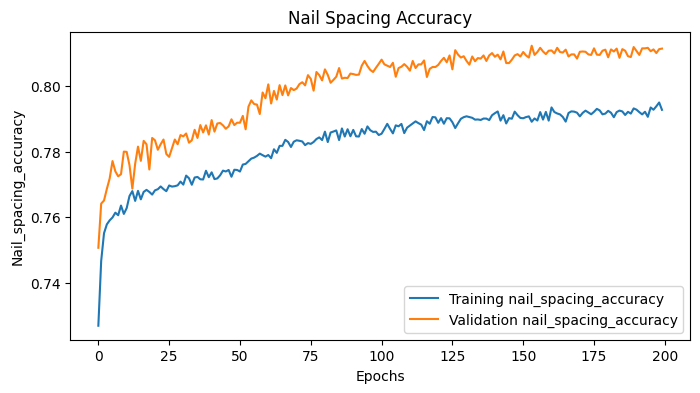

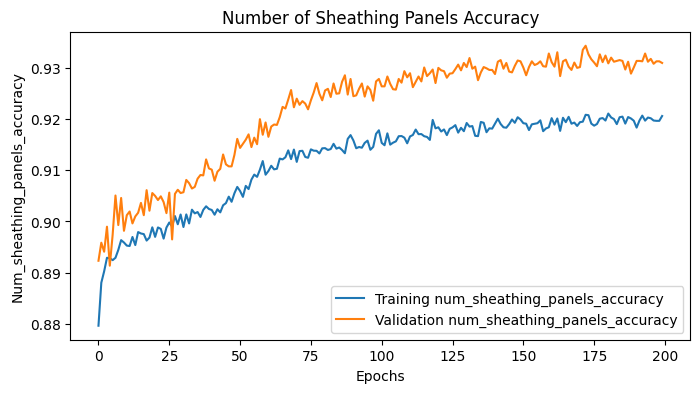

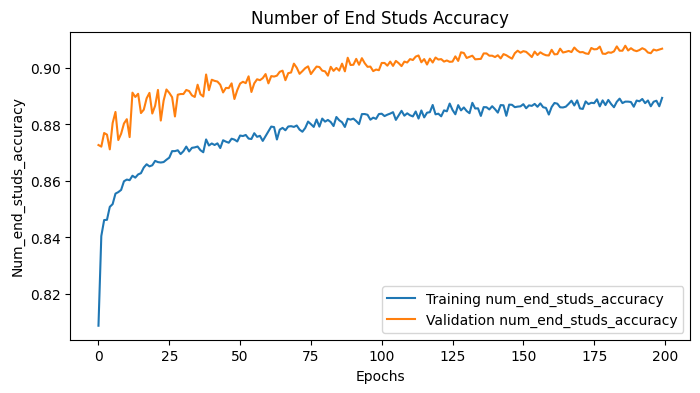

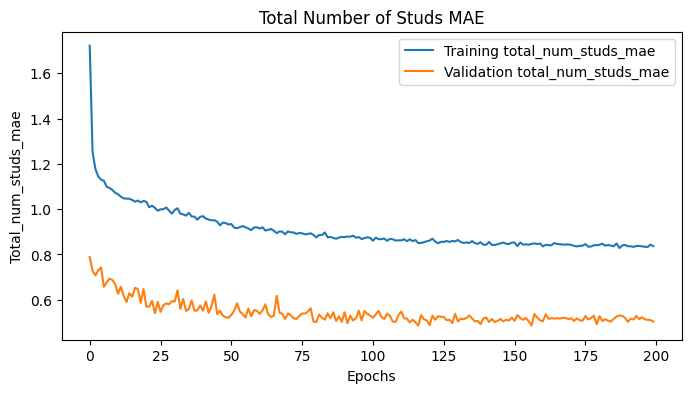

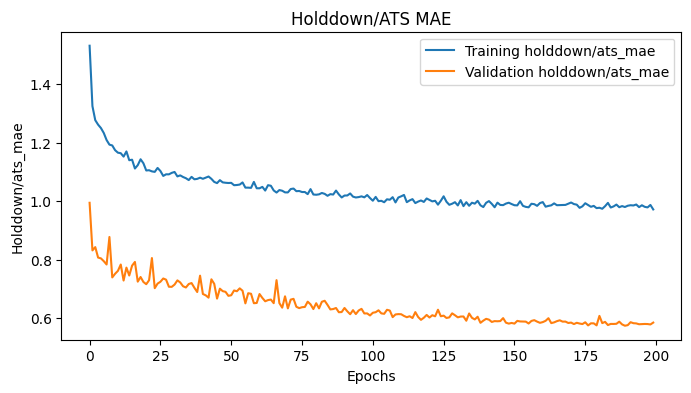

In [54]:
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on test data
eval_result = best_model.evaluate(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing,
                                               'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                               'num_end_studs': Y_test_onehot_num_end_studs,
                                               'total_num_studs': Y_test_C_1['Total number studs'],
                                               'holddown/ats': Y_test_C_1['HoldDown Model / ATS']})
print("Evaluation result on Test Data:", eval_result)


# Re-train the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = build_model(best_hps)
history = model.fit(X_train_C_1, {'nail_spacing': Y_train_onehot_nail_spacing, 
                                  'num_sheathing_panels': Y_train_onehot_num_sheathing_panels,
                                  'num_end_studs': Y_train_onehot_num_end_studs,
                                  'total_num_studs': Y_train_C_1['Total number studs'],
                                  'holddown/ats': Y_train_C_1['HoldDown Model / ATS']},
                    epochs=200,  # Number of epochs
                    validation_data=(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing,
                                                  'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                                  'num_end_studs': Y_test_onehot_num_end_studs,
                                                  'total_num_studs': Y_test_C_1['Total number studs'],
                                                  'holddown/ats': Y_test_C_1['HoldDown Model / ATS']}))

def plot_and_save_metrics(history, metric_name, title, filename):
    plt.figure(figsize=(8, 4))
    plt.plot(history.history[metric_name], label=f'Training {metric_name}')
    plt.plot(history.history[f'val_{metric_name}'], label=f'Validation {metric_name}')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    save_dir = './Files/Visualisation/NN/'
    plt.savefig(save_dir +'with_regularization' + filename)  # Save the plot to a file
    plt.show()

# Plot and save for each output
plot_and_save_metrics(history, 'nail_spacing_accuracy', 'Nail Spacing Accuracy', 'nail_spacing_accuracy.png')
plot_and_save_metrics(history, 'num_sheathing_panels_accuracy', 'Number of Sheathing Panels Accuracy', 'num_sheathing_panels_accuracy.png')
plot_and_save_metrics(history, 'num_end_studs_accuracy', 'Number of End Studs Accuracy', 'num_end_studs_accuracy.png')
plot_and_save_metrics(history, 'total_num_studs_mae', 'Total Number of Studs MAE', 'total_num_studs_mae.png')
plot_and_save_metrics(history, 'holddown/ats_mae', 'Holddown/ATS MAE', 'holddown_ats_mae.png')

In [55]:
def print_hyperparameters(best_hps, history):
    print("Best Hyperparameters:")
    for key, value in best_hps.values.items():
        print(f"{key}: {value}")

    # Print the best final accuracy and MAE for each output
    print("Best Final Accuracy and MAE:")
    print("Nail Spacing Accuracy:", history.history['nail_spacing_accuracy'][-1])
    print("Number of Sheathing Panels Accuracy:", history.history['num_sheathing_panels_accuracy'][-1])
    print("Number of End Studs Accuracy:", history.history['num_end_studs_accuracy'][-1])
    print("Total Number of Studs MAE:", history.history['total_num_studs_mae'][-1])
    print("Holddown/ATS MAE:", history.history['holddown/ats_mae'][-1])

In [56]:
print_hyperparameters(best_hps, history)

Best Hyperparameters:
num_layers: 2
units_0: 128
l1: 2.949043712495645e-05
l2: 0.00010164021724111836
leaky_alpha_0: 0.060000000000000005
dropout_0: 0.1
initial_learning_rate: 0.0020837831217781926
units_1: 128
leaky_alpha_1: 0.26
dropout_1: 0.1
units_2: 128
leaky_alpha_2: 0.26
dropout_2: 0.0
tuner/epochs: 10
tuner/initial_epoch: 2
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0003
Best Final Accuracy and MAE:
Nail Spacing Accuracy: 0.792812705039978
Number of Sheathing Panels Accuracy: 0.9206384420394897
Number of End Studs Accuracy: 0.8894197940826416
Total Number of Studs MAE: 0.8364722728729248
Holddown/ATS MAE: 0.9720830321311951


In [69]:
import kerastuner as kt
from tensorflow import keras
from keras.layers import Dense, Dropout, BatchNormalization, Input, LeakyReLU
from keras.regularizers import l1_l2
from keras.models import Model
import os
import shutil

# Path to the existing tuner directory
tuner_dir = 'my_dir/multi_output_tuning_reduced'

# Check if the directory exists and delete it
if os.path.exists(tuner_dir):
    shutil.rmtree(tuner_dir)

def build_model2(hp):
    input_layer = Input(shape=(X_train_C_1.shape[1],))
    x = input_layer

    # Tune the number of layers and their sizes
    for i in range(hp.Int('num_constructed_layers', 1, 3)):
        x = Dense(units=hp.Int('units_' + str(i), min_value=32, max_value=128, step=32),
                  activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.0, max_value=0.3, step=0.1))(x)

    # Output layers
    nail_spacing_output = Dense(3, activation='softmax', name='nail_spacing')(x)
    num_sheathing_panels_output = Dense(2, activation='softmax', name='num_sheathing_panels')(x)
    num_end_studs_output = Dense(6, activation='softmax', name='num_end_studs')(x)
    total_num_studs_output = Dense(1, activation='linear', name='total_num_studs')(x)
    holddown_model_output = Dense(1, activation='linear', name='holddown/ats')(x)

    model = Model(inputs=input_layer, outputs=[nail_spacing_output, num_sheathing_panels_output, 
                                               num_end_studs_output, total_num_studs_output, 
                                               holddown_model_output])

    # Learning rate schedule
    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=hp.Float('initial_learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG'),
        decay_steps=10000,
        decay_rate=0.9)

    # Compile the model
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss={'nail_spacing': 'categorical_crossentropy',
                        'num_sheathing_panels': 'categorical_crossentropy',
                        'num_end_studs': 'categorical_crossentropy',
                        'total_num_studs': 'mean_squared_error',
                        'holddown/ats': 'mean_squared_error'},
                  metrics={'nail_spacing': 'accuracy',
                           'num_sheathing_panels': 'accuracy',
                           'num_end_studs': 'accuracy',
                           'total_num_studs': 'mae',
                           'holddown/ats': 'mae'})

    return model

# Create a tuner instance
tuner = kt.Hyperband(build_model2,
                     objective='val_loss',
                     max_epochs=15,
                     factor=5,
                     directory='my_dir',
                     project_name='multi_output_tuning_reduced')

# Start the hyperparameter search
tuner.search(X_train_C_1, {'nail_spacing': Y_train_onehot_nail_spacing, 
                           'num_sheathing_panels': Y_train_onehot_num_sheathing_panels,
                           'num_end_studs': Y_train_onehot_num_end_studs,
                           'total_num_studs': Y_train_C_1['Total number studs'],
                           'holddown/ats': Y_train_C_1['HoldDown Model / ATS']},
             epochs=15,
             validation_data=(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing,
                                          'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                          'num_end_studs': Y_test_onehot_num_end_studs,
                                          'total_num_studs': Y_test_C_1['Total number studs'],
                                          'holddown/ats': Y_test_C_1['HoldDown Model / ATS']}))

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 13 Complete [00h 01m 04s]
val_loss: 3.3274664878845215

Best val_loss So Far: 3.3274664878845215
Total elapsed time: 00h 06m 30s


In [70]:
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model on test data
eval_result = best_model.evaluate(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing,
                                               'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                               'num_end_studs': Y_test_onehot_num_end_studs,
                                               'total_num_studs': Y_test_C_1['Total number studs'],
                                               'holddown/ats': Y_test_C_1['HoldDown Model / ATS']})
print("Evaluation result on Test Data:", eval_result)


# Re-train the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = build_model(best_hps)
history = model.fit(X_train_C_1, {'nail_spacing': Y_train_onehot_nail_spacing, 
                                  'num_sheathing_panels': Y_train_onehot_num_sheathing_panels,
                                  'num_end_studs': Y_train_onehot_num_end_studs,
                                  'total_num_studs': Y_train_C_1['Total number studs'],
                                  'holddown/ats': Y_train_C_1['HoldDown Model / ATS']},
                    epochs=200,  # Number of epochs
                    validation_data=(X_test_C_1, {'nail_spacing': Y_test_onehot_nail_spacing,
                                                  'num_sheathing_panels': Y_test_onehot_num_sheathing_panels,
                                                  'num_end_studs': Y_test_onehot_num_end_studs,
                                                  'total_num_studs': Y_test_C_1['Total number studs'],
                                                  'holddown/ats': Y_test_C_1['HoldDown Model / ATS']}))


390/390 [==============================] - 1s 2ms/step - loss: 3.3275 - nail_spacing_loss: 0.4883 - num_sheathing_panels_loss: 0.2032 - num_end_studs_loss: 0.2337 - total_num_studs_loss: 0.6406 - holddown/ats_loss: 1.7617 - nail_spacing_accuracy: 0.7784 - num_sheathing_panels_accuracy: 0.9021 - num_end_studs_accuracy: 0.8950 - total_num_studs_mae: 0.5377 - holddown/ats_mae: 0.7102
Evaluation result on Test Data: [3.3274664878845215, 0.4882690906524658, 0.2032299041748047, 0.23367175459861755, 0.6406399011611938, 1.7616544961929321, 0.7784469723701477, 0.9021119475364685, 0.8949650526046753, 0.5376943349838257, 0.7101517915725708]
Epoch 1/200
1557/1557 [==============================] - 6s 2ms/step - loss: 11.3883 - nail_spacing_loss: 0.6253 - num_sheathing_panels_loss: 0.2713 - num_end_studs_loss: 0.4527 - total_num_studs_loss: 4.1425 - holddown/ats_loss: 5.8701 - nail_spacing_accuracy: 0.7354 - num_sheathing_panels_accuracy: 0.8807 - num_end_studs_accuracy: 0.8138 - total_num_studs_ma

Epoch 11/200
1557/1557 [==============================] - 4s 2ms/step - loss: 6.5380 - nail_spacing_loss: 0.5518 - num_sheathing_panels_loss: 0.2229 - num_end_studs_loss: 0.3333 - total_num_studs_loss: 1.9215 - holddown/ats_loss: 3.3750 - nail_spacing_accuracy: 0.7631 - num_sheathing_panels_accuracy: 0.8973 - num_end_studs_accuracy: 0.8590 - total_num_studs_mae: 0.9966 - holddown/ats_mae: 1.1577 - val_loss: 4.2649 - val_nail_spacing_loss: 0.5226 - val_num_sheathing_panels_loss: 0.2081 - val_num_end_studs_loss: 0.2829 - val_total_num_studs_loss: 1.0424 - val_holddown/ats_loss: 2.0724 - val_nail_spacing_accuracy: 0.7716 - val_num_sheathing_panels_accuracy: 0.8973 - val_num_end_studs_accuracy: 0.8854 - val_total_num_studs_mae: 0.6850 - val_holddown/ats_mae: 0.8409
Epoch 12/200
1557/1557 [==============================] - 50s 32ms/step - loss: 6.4522 - nail_spacing_loss: 0.5548 - num_sheathing_panels_loss: 0.2240 - num_end_studs_loss: 0.3315 - total_num_studs_loss: 1.8942 - holddown/ats_lo

Epoch 22/200
1557/1557 [==============================] - 4s 2ms/step - loss: 5.9854 - nail_spacing_loss: 0.5380 - num_sheathing_panels_loss: 0.2161 - num_end_studs_loss: 0.3161 - total_num_studs_loss: 1.6845 - holddown/ats_loss: 3.0532 - nail_spacing_accuracy: 0.7689 - num_sheathing_panels_accuracy: 0.8993 - num_end_studs_accuracy: 0.8654 - total_num_studs_mae: 0.9321 - holddown/ats_mae: 1.0832 - val_loss: 3.8648 - val_nail_spacing_loss: 0.5150 - val_num_sheathing_panels_loss: 0.2116 - val_num_end_studs_loss: 0.2735 - val_total_num_studs_loss: 0.8483 - val_holddown/ats_loss: 1.8383 - val_nail_spacing_accuracy: 0.7774 - val_num_sheathing_panels_accuracy: 0.9035 - val_num_end_studs_accuracy: 0.8852 - val_total_num_studs_mae: 0.6165 - val_holddown/ats_mae: 0.7690
Epoch 23/200
1557/1557 [==============================] - 3s 2ms/step - loss: 6.0357 - nail_spacing_loss: 0.5396 - num_sheathing_panels_loss: 0.2176 - num_end_studs_loss: 0.3166 - total_num_studs_loss: 1.6843 - holddown/ats_loss

Epoch 33/200
1557/1557 [==============================] - 3s 2ms/step - loss: 5.7078 - nail_spacing_loss: 0.5340 - num_sheathing_panels_loss: 0.2161 - num_end_studs_loss: 0.3105 - total_num_studs_loss: 1.5745 - holddown/ats_loss: 2.8821 - nail_spacing_accuracy: 0.7695 - num_sheathing_panels_accuracy: 0.8990 - num_end_studs_accuracy: 0.8685 - total_num_studs_mae: 0.8993 - holddown/ats_mae: 1.0477 - val_loss: 4.0398 - val_nail_spacing_loss: 0.5092 - val_num_sheathing_panels_loss: 0.1979 - val_num_end_studs_loss: 0.2742 - val_total_num_studs_loss: 1.0473 - val_holddown/ats_loss: 1.8205 - val_nail_spacing_accuracy: 0.7787 - val_num_sheathing_panels_accuracy: 0.9038 - val_num_end_studs_accuracy: 0.8839 - val_total_num_studs_mae: 0.7251 - val_holddown/ats_mae: 0.7532
Epoch 34/200
1557/1557 [==============================] - 3s 2ms/step - loss: 5.7947 - nail_spacing_loss: 0.5341 - num_sheathing_panels_loss: 0.2126 - num_end_studs_loss: 0.3123 - total_num_studs_loss: 1.5842 - holddown/ats_loss

Epoch 44/200
1557/1557 [==============================] - 3s 2ms/step - loss: 5.6989 - nail_spacing_loss: 0.5303 - num_sheathing_panels_loss: 0.2111 - num_end_studs_loss: 0.3039 - total_num_studs_loss: 1.5468 - holddown/ats_loss: 2.9136 - nail_spacing_accuracy: 0.7726 - num_sheathing_panels_accuracy: 0.9014 - num_end_studs_accuracy: 0.8728 - total_num_studs_mae: 0.8885 - holddown/ats_mae: 1.0475 - val_loss: 3.7228 - val_nail_spacing_loss: 0.5092 - val_num_sheathing_panels_loss: 0.1979 - val_num_end_studs_loss: 0.2603 - val_total_num_studs_loss: 0.7536 - val_holddown/ats_loss: 1.8084 - val_nail_spacing_accuracy: 0.7785 - val_num_sheathing_panels_accuracy: 0.9040 - val_num_end_studs_accuracy: 0.8888 - val_total_num_studs_mae: 0.5876 - val_holddown/ats_mae: 0.7476
Epoch 45/200
1557/1557 [==============================] - 3s 2ms/step - loss: 5.6142 - nail_spacing_loss: 0.5321 - num_sheathing_panels_loss: 0.2123 - num_end_studs_loss: 0.3029 - total_num_studs_loss: 1.4943 - holddown/ats_loss

Epoch 55/200
1557/1557 [==============================] - 3s 2ms/step - loss: 5.5879 - nail_spacing_loss: 0.5300 - num_sheathing_panels_loss: 0.2124 - num_end_studs_loss: 0.3016 - total_num_studs_loss: 1.5022 - holddown/ats_loss: 2.8501 - nail_spacing_accuracy: 0.7708 - num_sheathing_panels_accuracy: 0.9021 - num_end_studs_accuracy: 0.8719 - total_num_studs_mae: 0.8778 - holddown/ats_mae: 1.0360 - val_loss: 3.6978 - val_nail_spacing_loss: 0.5168 - val_num_sheathing_panels_loss: 0.2012 - val_num_end_studs_loss: 0.2602 - val_total_num_studs_loss: 0.7395 - val_holddown/ats_loss: 1.7888 - val_nail_spacing_accuracy: 0.7734 - val_num_sheathing_panels_accuracy: 0.9047 - val_num_end_studs_accuracy: 0.8894 - val_total_num_studs_mae: 0.5931 - val_holddown/ats_mae: 0.7438
Epoch 56/200
1557/1557 [==============================] - 4s 2ms/step - loss: 5.4634 - nail_spacing_loss: 0.5275 - num_sheathing_panels_loss: 0.2113 - num_end_studs_loss: 0.2994 - total_num_studs_loss: 1.4939 - holddown/ats_loss

Epoch 66/200
1557/1557 [==============================] - 3s 2ms/step - loss: 5.4327 - nail_spacing_loss: 0.5280 - num_sheathing_panels_loss: 0.2100 - num_end_studs_loss: 0.2979 - total_num_studs_loss: 1.4670 - holddown/ats_loss: 2.7414 - nail_spacing_accuracy: 0.7740 - num_sheathing_panels_accuracy: 0.9022 - num_end_studs_accuracy: 0.8747 - total_num_studs_mae: 0.8683 - holddown/ats_mae: 1.0194 - val_loss: 3.8063 - val_nail_spacing_loss: 0.5042 - val_num_sheathing_panels_loss: 0.1947 - val_num_end_studs_loss: 0.2632 - val_total_num_studs_loss: 0.7401 - val_holddown/ats_loss: 1.9158 - val_nail_spacing_accuracy: 0.7834 - val_num_sheathing_panels_accuracy: 0.9059 - val_num_end_studs_accuracy: 0.8909 - val_total_num_studs_mae: 0.5821 - val_holddown/ats_mae: 0.7737
Epoch 67/200
1557/1557 [==============================] - 3s 2ms/step - loss: 5.3697 - nail_spacing_loss: 0.5289 - num_sheathing_panels_loss: 0.2089 - num_end_studs_loss: 0.2978 - total_num_studs_loss: 1.4365 - holddown/ats_loss

Epoch 77/200
1557/1557 [==============================] - 3s 2ms/step - loss: 5.3719 - nail_spacing_loss: 0.5228 - num_sheathing_panels_loss: 0.2056 - num_end_studs_loss: 0.2923 - total_num_studs_loss: 1.4494 - holddown/ats_loss: 2.7180 - nail_spacing_accuracy: 0.7767 - num_sheathing_panels_accuracy: 0.9056 - num_end_studs_accuracy: 0.8756 - total_num_studs_mae: 0.8579 - holddown/ats_mae: 1.0122 - val_loss: 3.5782 - val_nail_spacing_loss: 0.5012 - val_num_sheathing_panels_loss: 0.1911 - val_num_end_studs_loss: 0.2593 - val_total_num_studs_loss: 0.6961 - val_holddown/ats_loss: 1.7470 - val_nail_spacing_accuracy: 0.7835 - val_num_sheathing_panels_accuracy: 0.9072 - val_num_end_studs_accuracy: 0.8946 - val_total_num_studs_mae: 0.5729 - val_holddown/ats_mae: 0.7271
Epoch 78/200
1557/1557 [==============================] - 3s 2ms/step - loss: 5.3412 - nail_spacing_loss: 0.5250 - num_sheathing_panels_loss: 0.2057 - num_end_studs_loss: 0.2924 - total_num_studs_loss: 1.4426 - holddown/ats_loss

Epoch 88/200
1557/1557 [==============================] - 3s 2ms/step - loss: 5.2152 - nail_spacing_loss: 0.5180 - num_sheathing_panels_loss: 0.2006 - num_end_studs_loss: 0.2918 - total_num_studs_loss: 1.3992 - holddown/ats_loss: 2.6259 - nail_spacing_accuracy: 0.7791 - num_sheathing_panels_accuracy: 0.9108 - num_end_studs_accuracy: 0.8755 - total_num_studs_mae: 0.8524 - holddown/ats_mae: 0.9980 - val_loss: 3.7626 - val_nail_spacing_loss: 0.4920 - val_num_sheathing_panels_loss: 0.1866 - val_num_end_studs_loss: 0.2597 - val_total_num_studs_loss: 0.6990 - val_holddown/ats_loss: 1.9458 - val_nail_spacing_accuracy: 0.7886 - val_num_sheathing_panels_accuracy: 0.9126 - val_num_end_studs_accuracy: 0.8893 - val_total_num_studs_mae: 0.5685 - val_holddown/ats_mae: 0.7703
Epoch 89/200
1557/1557 [==============================] - 3s 2ms/step - loss: 5.2802 - nail_spacing_loss: 0.5136 - num_sheathing_panels_loss: 0.1992 - num_end_studs_loss: 0.2902 - total_num_studs_loss: 1.4318 - holddown/ats_loss

Epoch 99/200
1557/1557 [==============================] - 4s 3ms/step - loss: 5.1874 - nail_spacing_loss: 0.5162 - num_sheathing_panels_loss: 0.1968 - num_end_studs_loss: 0.2939 - total_num_studs_loss: 1.3735 - holddown/ats_loss: 2.6310 - nail_spacing_accuracy: 0.7809 - num_sheathing_panels_accuracy: 0.9125 - num_end_studs_accuracy: 0.8756 - total_num_studs_mae: 0.8427 - holddown/ats_mae: 0.9936 - val_loss: 3.5167 - val_nail_spacing_loss: 0.4859 - val_num_sheathing_panels_loss: 0.1777 - val_num_end_studs_loss: 0.2552 - val_total_num_studs_loss: 0.6792 - val_holddown/ats_loss: 1.7430 - val_nail_spacing_accuracy: 0.7920 - val_num_sheathing_panels_accuracy: 0.9176 - val_num_end_studs_accuracy: 0.8916 - val_total_num_studs_mae: 0.5588 - val_holddown/ats_mae: 0.7297
Epoch 100/200
1557/1557 [==============================] - 4s 3ms/step - loss: 5.1946 - nail_spacing_loss: 0.5168 - num_sheathing_panels_loss: 0.1944 - num_end_studs_loss: 0.2882 - total_num_studs_loss: 1.4065 - holddown/ats_los

Epoch 110/200
1557/1557 [==============================] - 3s 2ms/step - loss: 5.1351 - nail_spacing_loss: 0.5120 - num_sheathing_panels_loss: 0.1949 - num_end_studs_loss: 0.2869 - total_num_studs_loss: 1.4167 - holddown/ats_loss: 2.5523 - nail_spacing_accuracy: 0.7824 - num_sheathing_panels_accuracy: 0.9133 - num_end_studs_accuracy: 0.8795 - total_num_studs_mae: 0.8485 - holddown/ats_mae: 0.9761 - val_loss: 3.4225 - val_nail_spacing_loss: 0.4835 - val_num_sheathing_panels_loss: 0.1787 - val_num_end_studs_loss: 0.2543 - val_total_num_studs_loss: 0.6611 - val_holddown/ats_loss: 1.6726 - val_nail_spacing_accuracy: 0.7934 - val_num_sheathing_panels_accuracy: 0.9183 - val_num_end_studs_accuracy: 0.8914 - val_total_num_studs_mae: 0.5538 - val_holddown/ats_mae: 0.7149
Epoch 111/200
1557/1557 [==============================] - 3s 2ms/step - loss: 5.0939 - nail_spacing_loss: 0.5123 - num_sheathing_panels_loss: 0.1939 - num_end_studs_loss: 0.2889 - total_num_studs_loss: 1.3663 - holddown/ats_lo

Epoch 121/200
1557/1557 [==============================] - 4s 2ms/step - loss: 5.1633 - nail_spacing_loss: 0.5127 - num_sheathing_panels_loss: 0.1929 - num_end_studs_loss: 0.2898 - total_num_studs_loss: 1.3874 - holddown/ats_loss: 2.6115 - nail_spacing_accuracy: 0.7819 - num_sheathing_panels_accuracy: 0.9130 - num_end_studs_accuracy: 0.8784 - total_num_studs_mae: 0.8432 - holddown/ats_mae: 0.9870 - val_loss: 3.3764 - val_nail_spacing_loss: 0.4803 - val_num_sheathing_panels_loss: 0.1738 - val_num_end_studs_loss: 0.2522 - val_total_num_studs_loss: 0.6639 - val_holddown/ats_loss: 1.6373 - val_nail_spacing_accuracy: 0.7954 - val_num_sheathing_panels_accuracy: 0.9203 - val_num_end_studs_accuracy: 0.8935 - val_total_num_studs_mae: 0.5551 - val_holddown/ats_mae: 0.7028
Epoch 122/200
1557/1557 [==============================] - 4s 2ms/step - loss: 5.1124 - nail_spacing_loss: 0.5117 - num_sheathing_panels_loss: 0.1935 - num_end_studs_loss: 0.2884 - total_num_studs_loss: 1.3649 - holddown/ats_lo

Epoch 132/200
1557/1557 [==============================] - 3s 2ms/step - loss: 4.9895 - nail_spacing_loss: 0.5088 - num_sheathing_panels_loss: 0.1916 - num_end_studs_loss: 0.2855 - total_num_studs_loss: 1.3368 - holddown/ats_loss: 2.5004 - nail_spacing_accuracy: 0.7849 - num_sheathing_panels_accuracy: 0.9148 - num_end_studs_accuracy: 0.8798 - total_num_studs_mae: 0.8350 - holddown/ats_mae: 0.9722 - val_loss: 3.3605 - val_nail_spacing_loss: 0.4777 - val_num_sheathing_panels_loss: 0.1724 - val_num_end_studs_loss: 0.2526 - val_total_num_studs_loss: 0.6552 - val_holddown/ats_loss: 1.6363 - val_nail_spacing_accuracy: 0.7979 - val_num_sheathing_panels_accuracy: 0.9201 - val_num_end_studs_accuracy: 0.8960 - val_total_num_studs_mae: 0.5482 - val_holddown/ats_mae: 0.6977
Epoch 133/200
1557/1557 [==============================] - 3s 2ms/step - loss: 5.0689 - nail_spacing_loss: 0.5099 - num_sheathing_panels_loss: 0.1904 - num_end_studs_loss: 0.2869 - total_num_studs_loss: 1.3225 - holddown/ats_lo

Epoch 143/200
1557/1557 [==============================] - 3s 2ms/step - loss: 5.0115 - nail_spacing_loss: 0.5068 - num_sheathing_panels_loss: 0.1865 - num_end_studs_loss: 0.2852 - total_num_studs_loss: 1.3501 - holddown/ats_loss: 2.5194 - nail_spacing_accuracy: 0.7855 - num_sheathing_panels_accuracy: 0.9182 - num_end_studs_accuracy: 0.8800 - total_num_studs_mae: 0.8357 - holddown/ats_mae: 0.9720 - val_loss: 3.4745 - val_nail_spacing_loss: 0.4777 - val_num_sheathing_panels_loss: 0.1683 - val_num_end_studs_loss: 0.2551 - val_total_num_studs_loss: 0.6623 - val_holddown/ats_loss: 1.7476 - val_nail_spacing_accuracy: 0.7985 - val_num_sheathing_panels_accuracy: 0.9236 - val_num_end_studs_accuracy: 0.8942 - val_total_num_studs_mae: 0.5551 - val_holddown/ats_mae: 0.7369
Epoch 144/200
1557/1557 [==============================] - 3s 2ms/step - loss: 5.0543 - nail_spacing_loss: 0.5093 - num_sheathing_panels_loss: 0.1904 - num_end_studs_loss: 0.2828 - total_num_studs_loss: 1.3563 - holddown/ats_lo

Epoch 154/200
1557/1557 [==============================] - 3s 2ms/step - loss: 5.0756 - nail_spacing_loss: 0.5076 - num_sheathing_panels_loss: 0.1915 - num_end_studs_loss: 0.2844 - total_num_studs_loss: 1.3628 - holddown/ats_loss: 2.5678 - nail_spacing_accuracy: 0.7842 - num_sheathing_panels_accuracy: 0.9152 - num_end_studs_accuracy: 0.8789 - total_num_studs_mae: 0.8397 - holddown/ats_mae: 0.9768 - val_loss: 3.2874 - val_nail_spacing_loss: 0.4767 - val_num_sheathing_panels_loss: 0.1693 - val_num_end_studs_loss: 0.2490 - val_total_num_studs_loss: 0.6316 - val_holddown/ats_loss: 1.5994 - val_nail_spacing_accuracy: 0.7991 - val_num_sheathing_panels_accuracy: 0.9234 - val_num_end_studs_accuracy: 0.8923 - val_total_num_studs_mae: 0.5389 - val_holddown/ats_mae: 0.6900
Epoch 155/200
1557/1557 [==============================] - 4s 2ms/step - loss: 5.0225 - nail_spacing_loss: 0.5055 - num_sheathing_panels_loss: 0.1895 - num_end_studs_loss: 0.2840 - total_num_studs_loss: 1.3608 - holddown/ats_lo

Epoch 165/200
1557/1557 [==============================] - 3s 2ms/step - loss: 5.0259 - nail_spacing_loss: 0.5074 - num_sheathing_panels_loss: 0.1884 - num_end_studs_loss: 0.2850 - total_num_studs_loss: 1.3410 - holddown/ats_loss: 2.5447 - nail_spacing_accuracy: 0.7860 - num_sheathing_panels_accuracy: 0.9155 - num_end_studs_accuracy: 0.8799 - total_num_studs_mae: 0.8342 - holddown/ats_mae: 0.9798 - val_loss: 3.2585 - val_nail_spacing_loss: 0.4767 - val_num_sheathing_panels_loss: 0.1687 - val_num_end_studs_loss: 0.2496 - val_total_num_studs_loss: 0.6341 - val_holddown/ats_loss: 1.5700 - val_nail_spacing_accuracy: 0.7988 - val_num_sheathing_panels_accuracy: 0.9230 - val_num_end_studs_accuracy: 0.8926 - val_total_num_studs_mae: 0.5434 - val_holddown/ats_mae: 0.6823
Epoch 166/200
1557/1557 [==============================] - 3s 2ms/step - loss: 4.9974 - nail_spacing_loss: 0.5068 - num_sheathing_panels_loss: 0.1886 - num_end_studs_loss: 0.2823 - total_num_studs_loss: 1.3345 - holddown/ats_lo

Epoch 176/200
1557/1557 [==============================] - 3s 2ms/step - loss: 4.9635 - nail_spacing_loss: 0.5061 - num_sheathing_panels_loss: 0.1893 - num_end_studs_loss: 0.2843 - total_num_studs_loss: 1.3208 - holddown/ats_loss: 2.5051 - nail_spacing_accuracy: 0.7850 - num_sheathing_panels_accuracy: 0.9155 - num_end_studs_accuracy: 0.8795 - total_num_studs_mae: 0.8302 - holddown/ats_mae: 0.9742 - val_loss: 3.3203 - val_nail_spacing_loss: 0.4773 - val_num_sheathing_panels_loss: 0.1676 - val_num_end_studs_loss: 0.2497 - val_total_num_studs_loss: 0.6292 - val_holddown/ats_loss: 1.6388 - val_nail_spacing_accuracy: 0.7983 - val_num_sheathing_panels_accuracy: 0.9239 - val_num_end_studs_accuracy: 0.8946 - val_total_num_studs_mae: 0.5399 - val_holddown/ats_mae: 0.6978
Epoch 177/200
1557/1557 [==============================] - 3s 2ms/step - loss: 4.9713 - nail_spacing_loss: 0.5061 - num_sheathing_panels_loss: 0.1886 - num_end_studs_loss: 0.2829 - total_num_studs_loss: 1.3319 - holddown/ats_lo

Epoch 187/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.9951 - nail_spacing_loss: 0.5059 - num_sheathing_panels_loss: 0.1883 - num_end_studs_loss: 0.2821 - total_num_studs_loss: 1.3187 - holddown/ats_loss: 2.5438 - nail_spacing_accuracy: 0.7861 - num_sheathing_panels_accuracy: 0.9174 - num_end_studs_accuracy: 0.8809 - total_num_studs_mae: 0.8303 - holddown/ats_mae: 0.9758 - val_loss: 3.2467 - val_nail_spacing_loss: 0.4760 - val_num_sheathing_panels_loss: 0.1678 - val_num_end_studs_loss: 0.2487 - val_total_num_studs_loss: 0.6271 - val_holddown/ats_loss: 1.5708 - val_nail_spacing_accuracy: 0.7998 - val_num_sheathing_panels_accuracy: 0.9246 - val_num_end_studs_accuracy: 0.8944 - val_total_num_studs_mae: 0.5365 - val_holddown/ats_mae: 0.6806
Epoch 188/200
1557/1557 [==============================] - 3s 2ms/step - loss: 4.9674 - nail_spacing_loss: 0.5068 - num_sheathing_panels_loss: 0.1881 - num_end_studs_loss: 0.2859 - total_num_studs_loss: 1.3322 - holddown/ats_lo

Epoch 198/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.9618 - nail_spacing_loss: 0.5059 - num_sheathing_panels_loss: 0.1874 - num_end_studs_loss: 0.2842 - total_num_studs_loss: 1.3111 - holddown/ats_loss: 2.5180 - nail_spacing_accuracy: 0.7861 - num_sheathing_panels_accuracy: 0.9167 - num_end_studs_accuracy: 0.8806 - total_num_studs_mae: 0.8310 - holddown/ats_mae: 0.9661 - val_loss: 3.3548 - val_nail_spacing_loss: 0.4763 - val_num_sheathing_panels_loss: 0.1663 - val_num_end_studs_loss: 0.2493 - val_total_num_studs_loss: 0.6393 - val_holddown/ats_loss: 1.6685 - val_nail_spacing_accuracy: 0.7990 - val_num_sheathing_panels_accuracy: 0.9248 - val_num_end_studs_accuracy: 0.8938 - val_total_num_studs_mae: 0.5475 - val_holddown/ats_mae: 0.7087
Epoch 199/200
1557/1557 [==============================] - 4s 2ms/step - loss: 4.8964 - nail_spacing_loss: 0.5067 - num_sheathing_panels_loss: 0.1884 - num_end_studs_loss: 0.2807 - total_num_studs_loss: 1.3070 - holddown/ats_lo

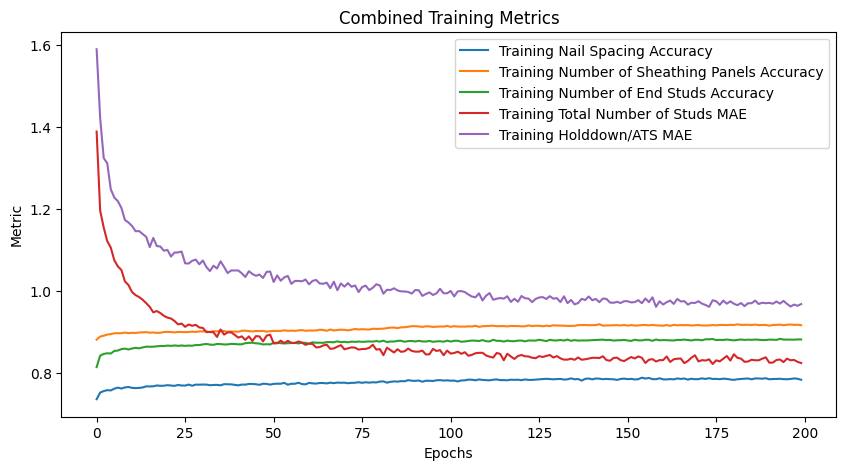

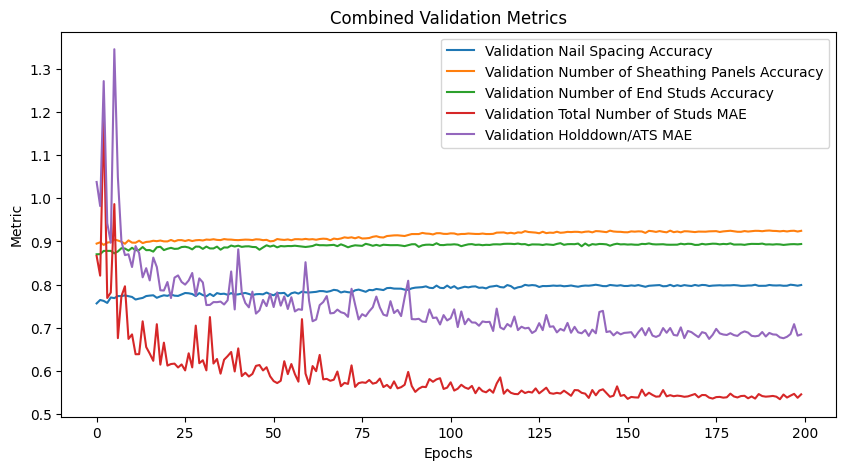

In [71]:
def plot_combined_metrics(history, metrics, titles, filename):
    plt.figure(figsize=(10, 5))

    # Plot all training metrics
    for metric, title in zip(metrics, titles):
        plt.plot(history.history[metric], label=f'Training {title}')
    
    plt.title('Combined Training Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()
    save_dir = './Files/Visualisation/NN/'
    plt.savefig(save_dir + 'combined_training_' + filename)  # Save the training plot
    plt.show()

    plt.figure(figsize=(10, 5))

    # Plot all validation metrics
    for metric, title in zip(metrics, titles):
        plt.plot(history.history[f'val_{metric}'], label=f'Validation {title}')

    plt.title('Combined Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Metric')
    plt.legend()
    plt.savefig(save_dir + 'combined_validation_' + filename)  # Save the validation plot
    plt.show()

# Define the metrics and their titles
metrics = ['nail_spacing_accuracy', 'num_sheathing_panels_accuracy', 'num_end_studs_accuracy', 'total_num_studs_mae', 'holddown/ats_mae']
titles = ['Nail Spacing Accuracy', 'Number of Sheathing Panels Accuracy', 'Number of End Studs Accuracy', 'Total Number of Studs MAE', 'Holddown/ATS MAE']

# Call the function with the history object, metrics, titles, and a filename
plot_combined_metrics(history, metrics, titles, 'combined_metrics.png')


In [72]:
print_hyperparameters(best_hps, history)

Best Hyperparameters:
num_constructed_layers: 3
units_0: 128
dropout_0: 0.1
initial_learning_rate: 0.00617050452258954
units_1: 64
dropout_1: 0.0
units_2: 128
dropout_2: 0.0
tuner/epochs: 15
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
num_layers: 1
l1: 1e-05
l2: 1e-05
leaky_alpha_0: 0.01
Best Final Accuracy and MAE:
Nail Spacing Accuracy: 0.782895028591156
Number of Sheathing Panels Accuracy: 0.9157398343086243
Number of End Studs Accuracy: 0.88102787733078
Total Number of Studs MAE: 0.8235653042793274
Holddown/ATS MAE: 0.9674012064933777
